<a href="https://colab.research.google.com/github/adityaharshsingh7/Face_mask_detection/blob/main/Face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_face_mask_detection_path = kagglehub.dataset_download('andrewmvd/face-mask-detection')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
import os


In [3]:
# Function to parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize variables for the image details
    label = None

    # Parse XML to get the label
    for member in root.findall('object'):
        label = member.find('name').text
        # Assuming we only need the label, not bounding box coordinates

    return label

In [4]:
# Paths
annotations_dir = '/kaggle/input/face-mask-detection/annotations/'
images_dir = '/kaggle/input/face-mask-detection/images/'

# Initialize lists to hold data
image_data = []
labels = []

# Loop over each XML file in the annotations folder
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        # Parse the XML to get the label
        xml_path = os.path.join(annotations_dir, xml_file)
        label = parse_xml(xml_path)

        # Corresponding image file
        image_file = xml_file.replace('.xml', '.png')
        image_path = os.path.join(images_dir, image_file)

        # Check if the image file exists
        if os.path.exists(image_path):
            # Read and resize image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))  # Resize to 128x128

            # Flatten the image for ANN
            image_flat = image.flatten()

            # Append data to lists
            image_data.append(image_flat)
            labels.append(label)

# Convert to numpy arrays
X = np.array(image_data)
y = np.array(labels)

In [5]:
from sklearn.preprocessing import LabelBinarizer

# Encode labels (e.g., 'with_mask' -> 0, 'without_mask' -> 1)
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

In [6]:
# Convert y_encoded to a Numpy array
y_encoded = np.array(y_encoded)

In [7]:
# Convert y_encoded to categorical if it's binary and single-label
if len(y_encoded.shape) == 1:
    print("true")
    y_encoded = to_categorical(y_encoded)

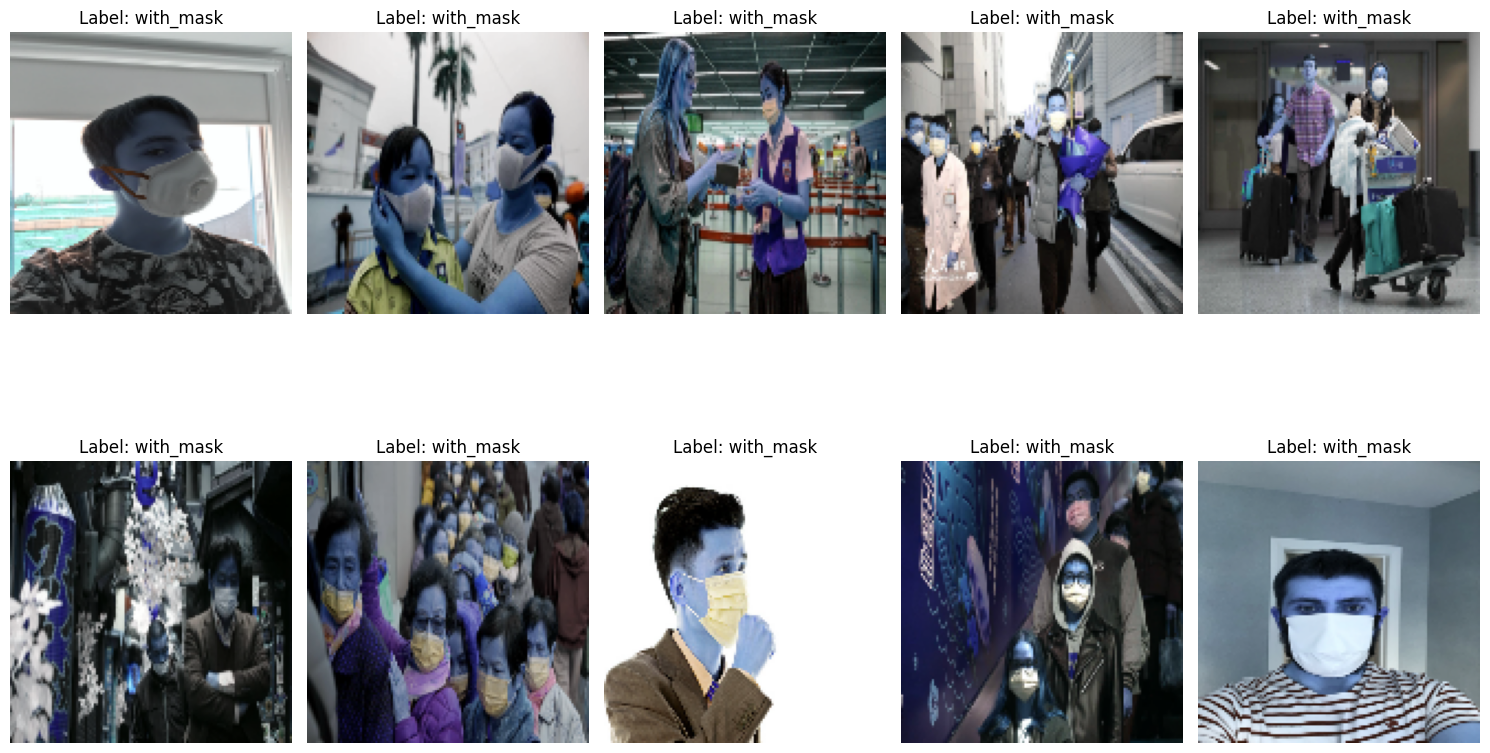

In [8]:
# Function to visualize images with their labels
def visualize_images(X, y_encoded, label_encoder, num_images=10):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X)), num_images)

    for i, idx in enumerate(indices):
        # Reshape the flattened image back to original dimensions
        image = X[idx].reshape(128, 128, 3)

        # Get the label index
        label_index = y_encoded[idx]

        # Decode the label
        label = label_encoder.inverse_transform([label_index])[0]

        # Plot each image in a grid
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.astype('uint8'))
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Fit the label encoder and transform labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Call the visualization function
visualize_images(X, y_encoded, label_encoder, num_images=10)

In [9]:
# Normalize pixel values to the range [0, 1]
X_normalized = X / 255.0

# One-hot encode labels for ANN
y_encoded_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded_one_hot, test_size=0.2, random_state=42)

# Check the shape of the training and testing data
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (682, 49152), Training labels shape: (682, 3)
Testing data shape: (171, 49152), Testing labels shape: (171, 3)


In [10]:
# Build the ANN model
model = Sequential([
    Flatten(input_shape=(49152,)),  # Flatten the 128x128x3 image to a 1D vector
    Dense(256, activation='relu'),  # Hidden layer with 256 neurons
    Dropout(0.5),                   # Dropout layer for regularization
    Dense(128, activation='relu'),  # Hidden layer with 128 neurons
    Dropout(0.5),                   # Dropout layer for regularization
    Dense(3, activation='softmax')  # Output layer for 3 classes (if one-hot encoded)
])

# Compile the model with an optimizer, loss, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,616,451 (48.13 MB)

 Trainable params: 12,616,451 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the ANN model
history = model.fit(
    X_train, y_train,
    epochs=20,                  # Number of epochs to train
    batch_size=32,              # Size of each training batch
    validation_data=(X_test, y_test),  # Use the test set for validation
    verbose=2                   # Verbose output
)


Epoch 1/20
22/22 - 12s - 545ms/step - accuracy: 0.5440 - loss: 18.1222 - val_accuracy: 0.7544 - val_loss: 6.9128
Epoch 2/20
22/22 - 10s - 473ms/step - accuracy: 0.5777 - loss: 6.5644 - val_accuracy: 0.7485 - val_loss: 0.8095
Epoch 3/20
22/22 - 17s - 778ms/step - accuracy: 0.6393 - loss: 1.0412 - val_accuracy: 0.7544 - val_loss: 0.8931
Epoch 4/20
22/22 - 9s - 393ms/step - accuracy: 0.7009 - loss: 0.9574 - val_accuracy: 0.7544 - val_loss: 0.8576
Epoch 5/20
22/22 - 10s - 447ms/step - accuracy: 0.7258 - loss: 0.8911 - val_accuracy: 0.7544 - val_loss: 0.8662
Epoch 6/20
22/22 - 6s - 262ms/step - accuracy: 0.7405 - loss: 0.8565 - val_accuracy: 0.7544 - val_loss: 0.8319
Epoch 7/20
22/22 - 10s - 453ms/step - accuracy: 0.7405 - loss: 0.8270 - val_accuracy: 0.7544 - val_loss: 0.7814
Epoch 8/20
22/22 - 9s - 422ms/step - accuracy: 0.7390 - loss: 0.7992 - val_accuracy: 0.7544 - val_loss: 1.0484
Epoch 9/20
22/22 - 6s - 280ms/step - accuracy: 0.7405 - loss: 0.8152 - val_accuracy: 0.7544 - val_loss: 0.

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot learning curves
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Build an improved ANN model with reduced regularization
improved_model = Sequential([
    Flatten(input_shape=(49152,)),  # Flatten the 128x128x3 image to a 1D vector

    # First Dense Block
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Reduced dropout rate

    # Second Dense Block
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third Dense Block
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Fourth Dense Block
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output Layer for 3 classes
    Dense(3, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam

# Adjusted learning rate
improved_optimizer = Adam(learning_rate=0.0005)

# Compile the improved model
improved_model.compile(optimizer=improved_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the improved model summary
improved_model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=10,               # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

# Define Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,           # Reduce the learning rate by a factor of 0.5
    patience=3,           # Wait for 3 epochs without improvement
    verbose=1,            # Verbosity mode
    min_lr=1e-6           # Minimum learning rate
)

# Train the improved model
history_improved = improved_model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],  # Include early stopping and learning rate scheduler
    verbose=2
)

In [ ]:
# Evaluate the improved model on the test set
test_loss, test_accuracy = improved_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy for Improved Model: {test_accuracy:.2f}")

# Plot learning curves for the improved model
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['accuracy'], label='Training Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.title('Improved Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Improved Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Reshape the input data to the original image shape (128x128x3)
X_train_reshaped = X_train.reshape(-1, 128, 128, 3)
X_test_reshaped = X_test.reshape(-1, 128, 128, 3)

# Build a simple CNN model
cnn_model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

In [ ]:
# Compile the CNN model
cnn_optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=cnn_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the CNN model summary
cnn_model.summary()

# Train the CNN model with Early Stopping
history_cnn = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, lr_scheduler],  # Include early stopping and learning rate scheduler
    verbose=2
)

In [ ]:
# Evaluate the CNN model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy for CNN Model: {test_accuracy:.2f}")

# Plot learning curves for the CNN model
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load MobileNetV2 with pre-trained weights, excluding the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom top layers for your specific dataset
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Combine the base model with custom layers
transfer_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the transfer learning model
transfer_optimizer = Adam(learning_rate=0.0001)
transfer_model.compile(optimizer=transfer_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the transfer learning model summary
transfer_model.summary()

# Train the transfer learning model
history_transfer = transfer_model.fit(
    X_train_reshaped, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, lr_scheduler],  # Include early stopping and learning rate scheduler
    verbose=2
)

In [ ]:
# Evaluate the transfer learning model on the test set
test_loss, test_accuracy = transfer_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy for Transfer Learning Model: {test_accuracy:.2f}")

# Plot learning curves for the transfer learning model
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Function to visualize predictions from the transfer learning model
def visualize_predictions(model, X_data, y_true, label_encoder, num_images=10):
    plt.figure(figsize=(15, 10))

    # Choose random indices to display
    indices = np.random.choice(range(len(X_data)), num_images, replace=False)

    for i, idx in enumerate(indices):
        # Get the image and true label
        image = X_data[idx]

        # If the image is normalized (0-1), rescale it back to 0-255
        if image.max() <= 1.0:
            image = (image * 255).astype('uint8')

        # If the image is flattened, reshape it back to (128, 128, 3)
        if image.shape != (128, 128, 3):
            image = image.reshape(128, 128, 3)

        # Ensure the image data type is uint8 for visualization
        if image.dtype != 'uint8':
            image = image.astype('uint8')

        # Get the true label
        true_label = label_encoder.inverse_transform([y_true[idx].argmax()])[0]

        # Predict the label using the transfer learning model
        prediction = model.predict(np.expand_dims(image / 255.0, axis=0))  # Normalize image for prediction
        predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]

        # Plot each image in a grid
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function using the correct model name 'transfer_model'
visualize_predictions(transfer_model, X_test_reshaped, y_test, label_encoder, num_images=10)